# Implementation 1: Using LSTM to predict Nvidia Closing Price

#### Motivation

The motivation of the project is to predict the closing stock price of Nvidia from 24 October - 4 November (10 Trading days). Model performance will be compared using RMSE.

#### Model of choice

The machine learning model of choice for implementation 1 will be the Long Short-Term Memory (LSTM) Neural Network. The reason for this choice of LSTMs is due to its ability to learn from longer term trends in the dataset, and also learn from more parameters, as compared to other Recurrant Neural Networks like SimpleRNN. Considering this is a time series forecasting project, LSTM would appear to be the most suitable model. 

#### Macroeconomic outlook for Nvidia

With expectations of continuing fed rate increases for the rest of 2022 and a high inflation-rate environment, general market sentiment is bearish. Nvidia has seen a YTD return of -60% and sits at around 112USD (14 October closing price), a far cry from its astronomical highs of 320USD just last year December. Reasons for the poor performance can be attributed to weakening demand for their chips due to economic slowdown, as well as factors such as appreciation of the US dollar (will be explained in the next segment). Ideally some of these factors will be incorporated as parameters into the model. 

#### Selection of Parameters

To predict Nvidia closing price, choosing the relevant parameters to Nvidia and its market characteristics is important.

For starters, price data will be incorporated as parameters, specifically the open, high, low and close daily price data for Nvidia. The intution is that perhaps previous prices would be of certain importance to the future price action of stocks, which is essentially technical analysis. 

Parameters that capture macroeconomic conditions will be important to the price prediction as well. One of the reasons for Nvidia's poor performance this year is due to the strong appreciation of USD (in part due to a multitude of reasons that include rising interest rates and a drop in investor confidence that caused a flock to the world's reserve currency). Nvidia is heavily reliant on foreign markets for both chip production and sales, and a strong US dollar results in higher price of goods in overseas markets, and lower demand for USD denomiated goods. 
- In order to capture this macroeconomic factor, the USD/CNY daily exchange rate will be used as a parameter, as Nvidia exports a significant portion of chips to China, as well as having parts of its production based in China. 
- Another parameter that will be used is the US Producer Price Index (month on month change), which is released monthly by the US Bureau of Labour Statistics. This is to capture costs incurred by producers, which could be useful to explain producer demand and the overall economic climate.

To sum up, list of parameters:
- Daily Open Price
- Daily High Price
- Daily Low Price
- Daily Close Price
- Daily USD/CNY exchange rate
- Monthly US PPI month on month

Data from the past 2 years will be used for building the model.

#### Import Libraries 

In [795]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping


from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

#### Import Nvidia Prices

In [796]:
nvda = yf.Ticker("NVDA")

In [797]:
start_date = '2020-10-21'
nvda_df = nvda.history(start = start_date)
nvda_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-10-21,135.998531,137.660452,134.526247,134.997879,21959600,0.0,0.0
2020-10-22,134.975444,135.866283,132.073308,133.363419,29048000,0.0,0.0
2020-10-23,134.251764,135.681616,132.667201,135.651672,23348400,0.0,0.0
2020-10-26,134.022223,136.674820,130.144383,131.169998,33689600,0.0,0.0
2020-10-27,132.814419,134.171910,131.671528,133.720245,25052000,0.0,0.0
...,...,...,...,...,...,...,...
2022-10-17,115.180000,119.480003,115.169998,118.879997,58077400,0.0,0.0
2022-10-18,123.440002,124.919998,116.180000,119.669998,65936200,0.0,0.0
2022-10-19,118.790001,123.500000,118.339996,120.510002,52313100,0.0,0.0


Choose to drop the columns dividends, stock splits, and volume from price dataset

In [798]:
nvda_df.drop(columns = ['Dividends', 'Stock Splits', 'Volume'], inplace = True)
nvda_df

,Open,High,Low,Close
Date,,,,
2020-10-21,135.998531,137.660452,134.526247,134.997879
2020-10-22,134.975444,135.866283,132.073308,133.363419
2020-10-23,134.251764,135.681616,132.667201,135.651672
2020-10-26,134.022223,136.674820,130.144383,131.169998
2020-10-27,132.814419,134.171910,131.671528,133.720245
...,...,...,...,...
2022-10-17,115.180000,119.480003,115.169998,118.879997
2022-10-18,123.440002,124.919998,116.180000,119.669998
2022-10-19,118.790001,123.500000,118.339996,120.510002


<AxesSubplot:xlabel='Date'>

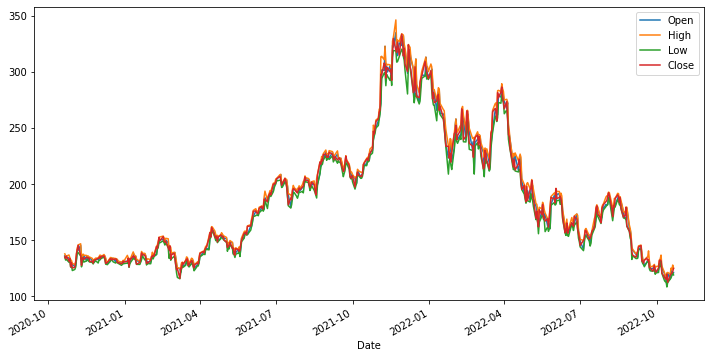

In [799]:
#plot open, high, low, close prices for visualisation
nvda_df.plot(figsize = (12,6))

#### Import USD/CNY Prices

USD CNY rates are obtained from yahoo finance as well, this time saved into a csv

In [800]:
usd_cny_df = pd.read_csv('USDCNY=X.csv')
usd_cny_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-10-21,6.6752,6.6757,6.6376,6.6752,6.6752,0
1,2020-10-22,6.6500,6.6876,6.6470,6.6500,6.6500,0
2,2020-10-23,6.6835,6.6916,6.6602,6.6835,6.6835,0
3,2020-10-26,6.6858,6.7132,6.6782,6.6857,6.6857,0
4,2020-10-27,6.7113,6.7227,6.6963,6.7113,6.7113,0
...,...,...,...,...,...,...,...
519,2022-10-18,7.1955,7.2011,7.1826,7.1955,7.1955,0
520,2022-10-19,7.2006,7.2290,7.1972,7.2006,7.2006,0
521,2022-10-20,7.2273,7.2423,7.2126,7.2273,7.2273,0
522,2022-10-21,7.2158,7.2499,7.2154,7.2158,7.2158,0


In [801]:
# change date column to datetime format
usd_cny_df['Date'] = pd.to_datetime(usd_cny_df['Date'])
usd_cny_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-10-21,6.6752,6.6757,6.6376,6.6752,6.6752,0
1,2020-10-22,6.6500,6.6876,6.6470,6.6500,6.6500,0
2,2020-10-23,6.6835,6.6916,6.6602,6.6835,6.6835,0
3,2020-10-26,6.6858,6.7132,6.6782,6.6857,6.6857,0
4,2020-10-27,6.7113,6.7227,6.6963,6.7113,6.7113,0
...,...,...,...,...,...,...,...
519,2022-10-18,7.1955,7.2011,7.1826,7.1955,7.1955,0
520,2022-10-19,7.2006,7.2290,7.1972,7.2006,7.2006,0
521,2022-10-20,7.2273,7.2423,7.2126,7.2273,7.2273,0
522,2022-10-21,7.2158,7.2499,7.2154,7.2158,7.2158,0


In [802]:
#set date as index
usd_cny_df.set_index('Date', inplace = True)
usd_cny_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-10-21,6.6752,6.6757,6.6376,6.6752,6.6752,0
2020-10-22,6.6500,6.6876,6.6470,6.6500,6.6500,0
2020-10-23,6.6835,6.6916,6.6602,6.6835,6.6835,0
2020-10-26,6.6858,6.7132,6.6782,6.6857,6.6857,0
2020-10-27,6.7113,6.7227,6.6963,6.7113,6.7113,0


In [803]:
# filter for only Closing Prices for USDCNY exchange
usd_cny_df = usd_cny_df['Close']
# rename Close columna name to USDCNY
usd_cny_df.name = 'USDCNY'

#### Import PPI US Data

PPI US data is obtained from Forex Factory, a website that shows economic calendar data for a pool of countries. 

In [804]:
ppi_us_df = pd.read_csv('PPIUSD.csv', header=None)

# filter for relevant columns
ppi_us_df = ppi_us_df.iloc[:,[0,3]]

# naming columns
ppi_us_df.columns = ['Date','PPIUS']
ppi_us_df

,Date,PPIUS
0,"Sep 14, 2022",-0.1
1,"Aug 11, 2022",-0.5
2,"Jul 14, 2022",1.1
3,"Jun 14, 2022",0.8
4,"May 12, 2022",0.5
...,...,...
135,"Jun 14, 2011",0.2
136,"May 12, 2011",0.8
137,"Apr 14, 2011",0.7
138,"Mar 16, 2011",1.6


In [805]:
# change Date to datetime format, and set Date column as index
ppi_us_df['Date'] = pd.to_datetime(ppi_us_df['Date'])
ppi_us_df.set_index('Date', inplace = True)

In [806]:
from datetime import datetime
# resample PPI US data to daily format, and ffill to fill NA values
ppi_us_df = ppi_us_df.resample('1d').ffill()

#filter for relevant dates
ppi_us_df = ppi_us_df[datetime(2020,10,21):]
ppi_us_df

,PPIUS
Date,
2020-10-21,0.4
2020-10-22,0.4
2020-10-23,0.4
2020-10-24,0.4
2020-10-25,0.4
...,...
2022-09-10,-0.5
2022-09-11,-0.5
2022-09-12,-0.5


#### Merge Datasets and data cleaning

In [807]:
# merging nvidia price and USD CNY datasets first
df = pd.concat([nvda_df, usd_cny_df], axis = 1)

In [808]:
df

,Open,High,Low,Close,USDCNY
Date,,,,,
2020-10-21,135.998531,137.660452,134.526247,134.997879,6.6752
2020-10-22,134.975444,135.866283,132.073308,133.363419,6.6500
2020-10-23,134.251764,135.681616,132.667201,135.651672,6.6835
2020-10-26,134.022223,136.674820,130.144383,131.169998,6.6857
2020-10-27,132.814419,134.171910,131.671528,133.720245,6.7113
...,...,...,...,...,...
2022-10-18,123.440002,124.919998,116.180000,119.669998,7.1955
2022-10-19,118.790001,123.500000,118.339996,120.510002,7.2006
2022-10-20,121.129997,127.690002,121.050003,121.940002,7.2273


In [809]:
# check for NA values in columns
df.isna().any()

Open       True
High       True
Low        True
Close      True
USDCNY    False
dtype: bool

In [810]:
#NA values arise due to the merging of price and exchange rate datasets
df.dropna(inplace = True)

In [811]:
df.isna().any()

Open      False
High      False
Low       False
Close     False
USDCNY    False
dtype: bool

In [812]:
df

,Open,High,Low,Close,USDCNY
Date,,,,,
2020-10-21,135.998531,137.660452,134.526247,134.997879,6.6752
2020-10-22,134.975444,135.866283,132.073308,133.363419,6.6500
2020-10-23,134.251764,135.681616,132.667201,135.651672,6.6835
2020-10-26,134.022223,136.674820,130.144383,131.169998,6.6857
2020-10-27,132.814419,134.171910,131.671528,133.720245,6.7113
...,...,...,...,...,...
2022-10-17,115.180000,119.480003,115.169998,118.879997,7.1900
2022-10-18,123.440002,124.919998,116.180000,119.669998,7.1955
2022-10-19,118.790001,123.500000,118.339996,120.510002,7.2006


In [813]:
# concat df with PPI US dataset
df = pd.concat([df, ppi_us_df], axis = 1)
df

,Open,High,Low,Close,USDCNY,PPIUS
Date,,,,,,
2020-10-21,135.998531,137.660452,134.526247,134.997879,6.6752,0.4
2020-10-22,134.975444,135.866283,132.073308,133.363419,6.6500,0.4
2020-10-23,134.251764,135.681616,132.667201,135.651672,6.6835,0.4
2020-10-24,NaN,NaN,NaN,NaN,NaN,0.4
2020-10-25,NaN,NaN,NaN,NaN,NaN,0.4
...,...,...,...,...,...,...
2022-10-17,115.180000,119.480003,115.169998,118.879997,7.1900,NaN
2022-10-18,123.440002,124.919998,116.180000,119.669998,7.1955,NaN
2022-10-19,118.790001,123.500000,118.339996,120.510002,7.2006,NaN


In [814]:
# ffill the NA values at the bottom of the dataset for PPIUS
df.ffill(inplace = True)
df

,Open,High,Low,Close,USDCNY,PPIUS
Date,,,,,,
2020-10-21,135.998531,137.660452,134.526247,134.997879,6.6752,0.4
2020-10-22,134.975444,135.866283,132.073308,133.363419,6.6500,0.4
2020-10-23,134.251764,135.681616,132.667201,135.651672,6.6835,0.4
2020-10-24,134.251764,135.681616,132.667201,135.651672,6.6835,0.4
2020-10-25,134.251764,135.681616,132.667201,135.651672,6.6835,0.4
...,...,...,...,...,...,...
2022-10-17,115.180000,119.480003,115.169998,118.879997,7.1900,-0.1
2022-10-18,123.440002,124.919998,116.180000,119.669998,7.1955,-0.1
2022-10-19,118.790001,123.500000,118.339996,120.510002,7.2006,-0.1


#### Data Preprocessing

In [815]:
target_y = df['Close']
target_y.name = 'Target_Close'
X_features = df

First, we will normalise the features using a standard normal distribution using StandardScaler.

In [816]:
sc = StandardScaler()
X_ft = sc.fit_transform(X_features.values)
X_ft = pd.DataFrame(columns = X_features.columns, data = X_ft, index = X_features.index)
X_ft

,Open,High,Low,Close,USDCNY,PPIUS
Date,,,,,,
2020-10-21,-0.970110,-0.981866,-0.952675,-0.990522,0.776862,-0.487188
2020-10-22,-0.988751,-1.013762,-0.998910,-1.020531,0.639813,-0.487188
2020-10-23,-1.001937,-1.017045,-0.987716,-0.978518,0.822001,-0.487188
2020-10-24,-1.001937,-1.017045,-0.987716,-0.978518,0.822001,-0.487188
2020-10-25,-1.001937,-1.017045,-0.987716,-0.978518,0.822001,-0.487188
...,...,...,...,...,...,...
2022-10-17,-1.349442,-1.305070,-1.317518,-1.286455,3.576569,-1.633608
2022-10-18,-1.198938,-1.208360,-1.298481,-1.271950,3.606480,-1.633608
2022-10-19,-1.283665,-1.233604,-1.257767,-1.256527,3.634216,-1.633608


Merge back normalised values with target y

In [817]:
df_ft = pd.concat([X_ft, target_y], axis = 1)
df_ft

,Open,High,Low,Close,USDCNY,PPIUS,Target_Close
Date,,,,,,,
2020-10-21,-0.970110,-0.981866,-0.952675,-0.990522,0.776862,-0.487188,134.997879
2020-10-22,-0.988751,-1.013762,-0.998910,-1.020531,0.639813,-0.487188,133.363419
2020-10-23,-1.001937,-1.017045,-0.987716,-0.978518,0.822001,-0.487188,135.651672
2020-10-24,-1.001937,-1.017045,-0.987716,-0.978518,0.822001,-0.487188,135.651672
2020-10-25,-1.001937,-1.017045,-0.987716,-0.978518,0.822001,-0.487188,135.651672
...,...,...,...,...,...,...,...
2022-10-17,-1.349442,-1.305070,-1.317518,-1.286455,3.576569,-1.633608,118.879997
2022-10-18,-1.198938,-1.208360,-1.298481,-1.271950,3.606480,-1.633608,119.669998
2022-10-19,-1.283665,-1.233604,-1.257767,-1.256527,3.634216,-1.633608,120.510002


Splitting of data into windows of size n for LSTM model
- LSTM model requires data to be segmented into blocks, where n is the number of samples for each feature. These data samples will be used to predict the nth target variable.
- Due to the nature of the project, we want to predict closing prices for 2 weeks, which would comprise of 10 training days. Therefore, n_future = 10
- Intuitively, we set the number of days we want to use to predict prices to be 5, which will be 1 week. 
- The model will use (T-4,T-3,T-2,T) closing price data to predict T+10 closing price. This is my workaround for multivariate time series forecasting.

In [818]:
#Number of days we want to predict into the future. Set to be 10 because the project objective is to forecast price data for 2 weeks (10 trading days).
n_future = 10

n_past = 5
#Number of days we want to use to predict the future


def split_lstm(data, n_future, n_past):
    """
    Creates features array and target variable array (windowed data of size n) from original dataframe
    """

    X, y, X_actualtest = [], [], []
    # X_actualtest is the set X values to be used to obtain the prediction price values
    for i in range(n_past, len(data) - n_future + 1):
        X.append(data.iloc[i- n_past:i, :-1].values)
        y.append(data.iloc[i + n_future - 1:i + n_future, -1])
    
    for i in range(len(df_ft) - n_future + 1, len(df_ft) + 1):
        X_actualtest.append(df_ft.iloc[i-n_past:i, :-1].values)

    return np.array(X), np.array(y), np.array(X_actualtest)

In [819]:
X, y, X_actualtest = split_lstm(df_ft, n_future, n_past)

#check output if splitting is done correctly
print('Last index for X:')
print(X[-1])
print('Last index for y')
print(y[-1])
print('First index for X_actualtest:')
print(X_actualtest[0])
print('Last index for X_actualtest:')
print(X_actualtest[-1])
df_ft.tail(20)

Last index for X:
[[-1.19839091 -1.17529392 -1.20668655 -1.17188523  3.16868618 -1.63360758]
 [-1.10145581 -1.07893978 -1.06079653 -1.05162361  3.16814234 -1.63360758]
 [-1.09562499 -1.06098431 -1.10942649 -1.0439122   3.16868618 -1.63360758]
 [-1.03932244 -1.00142977 -1.01857497 -1.05841693  3.16868618 -1.63360758]
 [-1.16960184 -1.17671616 -1.22233114 -1.25193731  3.16868618 -1.63360758]]
Last index for y
[124.66000366]
First index for X_actualtest:
[[-1.10145581 -1.07893978 -1.06079653 -1.05162361  3.16814234 -1.63360758]
 [-1.09562499 -1.06098431 -1.10942649 -1.0439122   3.16868618 -1.63360758]
 [-1.03932244 -1.00142977 -1.01857497 -1.05841693  3.16868618 -1.63360758]
 [-1.16960184 -1.17671616 -1.22233114 -1.25193731  3.16868618 -1.63360758]
 [-1.25487571 -1.27378142 -1.33806314 -1.32648131  3.16868618 -1.63360758]]
Last index for X_actualtest:
[[-1.34944228 -1.30506976 -1.31751795 -1.28645527  3.57656897 -1.63360758]
 [-1.19893752 -1.20836013 -1.29848056 -1.2719504   3.60648038 -1

,Open,High,Low,Close,USDCNY,PPIUS,Target_Close
Date,,,,,,,
2022-09-26,-1.172153,-1.178672,-1.186141,-1.224029,3.236123,-1.633608,122.279999
2022-09-27,-1.169237,-1.164983,-1.177848,-1.190062,3.348155,-1.633608,124.129997
2022-09-28,-1.186912,-1.149517,-1.159753,-1.130758,3.504782,-1.633608,127.360001
2022-09-29,-1.179988,-1.206938,-1.236656,-1.225498,3.625515,-1.633608,122.199997
2022-09-30,-1.245765,-1.183294,-1.212341,-1.240370,3.217088,-1.633608,121.389999
2022-10-03,-1.198391,-1.175294,-1.206687,-1.171885,3.168686,-1.633608,125.120003
2022-10-04,-1.101456,-1.078940,-1.060797,-1.051624,3.168142,-1.633608,131.669998
2022-10-05,-1.095625,-1.060984,-1.109426,-1.043912,3.168686,-1.633608,132.089996
2022-10-06,-1.039322,-1.001430,-1.018575,-1.058417,3.168686,-1.633608,131.300003


In [820]:
# check if shape of X_actualtest makes sense
X_actualtest.shape

(10, 5, 6)

#### Create train test splits

In [821]:
train_test_split = 0.8


split_index = int(len(X)*train_test_split)
date_index = df_ft.index[n_past+n_future-1:]

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
X_train_date, X_test_date = date_index[:split_index], date_index[split_index:]

print(X.shape, X_train.shape, X_test.shape)
print(y.shape, y_train.shape, y_test.shape)
print(X_train_date.shape, X_test_date.shape)

(707, 5, 6) (565, 5, 6) (142, 5, 6)
(707, 1) (565, 1) (142, 1)
(565,) (142,)


In [822]:
# sanity check if the first value of date_index corresponds with the appropriate y_train value
print(date_index[0])
print(y_train[0])
df_ft.head(15)

2020-11-04 00:00:00
[137.68792725]


,Open,High,Low,Close,USDCNY,PPIUS,Target_Close
Date,,,,,,,
2020-10-21,-0.970110,-0.981866,-0.952675,-0.990522,0.776862,-0.487188,134.997879
2020-10-22,-0.988751,-1.013762,-0.998910,-1.020531,0.639813,-0.487188,133.363419
2020-10-23,-1.001937,-1.017045,-0.987716,-0.978518,0.822001,-0.487188,135.651672
2020-10-24,-1.001937,-1.017045,-0.987716,-0.978518,0.822001,-0.487188,135.651672
2020-10-25,-1.001937,-1.017045,-0.987716,-0.978518,0.822001,-0.487188,135.651672
2020-10-26,-1.006120,-0.999389,-1.035268,-1.060804,0.833965,-0.487188,131.169998
2020-10-27,-1.028127,-1.043884,-1.006483,-1.013980,0.973189,-0.487188,133.720245
2020-10-28,-1.047769,-1.076179,-1.116075,-1.155049,0.935664,-0.487188,126.036957
2020-10-29,-1.113153,-1.088113,-1.089547,-1.082292,1.063467,-0.487188,129.999634


#### Building the LSTM Model

After tweaking and testing out parameters, the LSTM model finalized has 2 LSTM layers, one with 64 units and the other with 32 units, and a Dense layer with 1 unit.

In [823]:
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'relu', return_sequences=True))
lstm_model.add(LSTM(32, activation= 'relu'))
lstm_model.add(Dense(1))
lstm_model.compile(loss = "mse", optimizer = 'adam')
lstm_model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 5, 64)             18176     
                                                                 
 lstm_43 (LSTM)              (None, 32)                12416     
                                                                 
 dense_21 (Dense)            (None, 1)                 33        
                                                                 
Total params: 30,625
Trainable params: 30,625
Non-trainable params: 0
_________________________________________________________________


In [824]:
history = lstm_model.fit(X_train, y_train, epochs=100, batch_size = 12, shuffle=False)

Epoch 1/100
48/48 [==============================] - 3s 11ms/step - loss: 42074.5781
Epoch 2/100
48/48 [==============================] - 1s 11ms/step - loss: 52565.4609
Epoch 3/100
48/48 [==============================] - 1s 11ms/step - loss: 25026.1660
Epoch 4/100
48/48 [==============================] - 1s 11ms/step - loss: 14262.9805
Epoch 5/100
48/48 [==============================] - 1s 11ms/step - loss: 17028.7617
Epoch 6/100
48/48 [==============================] - 0s 10ms/step - loss: 12366.1904
Epoch 7/100
48/48 [==============================] - 1s 11ms/step - loss: 7792.6460
Epoch 8/100
48/48 [==============================] - 1s 11ms/step - loss: 6188.8594
Epoch 9/100
48/48 [==============================] - 1s 11ms/step - loss: 5433.0830
Epoch 10/100
48/48 [==============================] - 1s 11ms/step - loss: 4478.1587
Epoch 11/100
48/48 [==============================] - 1s 11ms/step - loss: 3857.1965
Epoch 12/100
48/48 [==============================] - 1s 11ms/step -

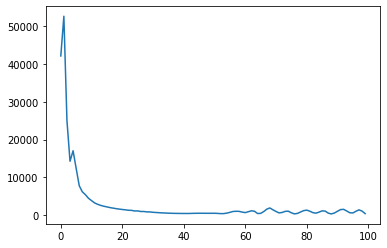

In [825]:
loss_per_epoch = lstm_model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

Plotting of loss per epoch shows that loss plateaus out around the 40th iteration.

#### Plotting Training Predictions

18/18 [==============================] - 0s 3ms/step
RMSE 24.612649266298305


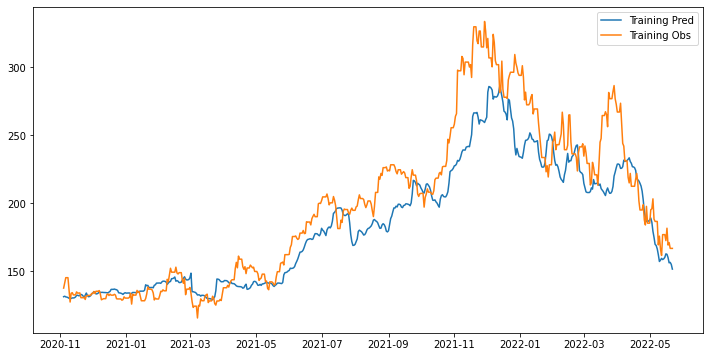

In [833]:
# Plotting training predictions
train_pred = lstm_model.predict(X_train).flatten()
plt.figure(figsize=(12,6))
plt.plot(X_train_date, train_pred)
plt.plot(X_train_date, y_train)
plt.legend(['Training Pred', 'Training Obs'])
rmse = mean_squared_error(y_train, train_pred, squared=False)
print('RMSE', rmse)

#### Plotting testing data predictions

5/5 [==============================] - 0s 2ms/step
RMSE 24.653124748549494


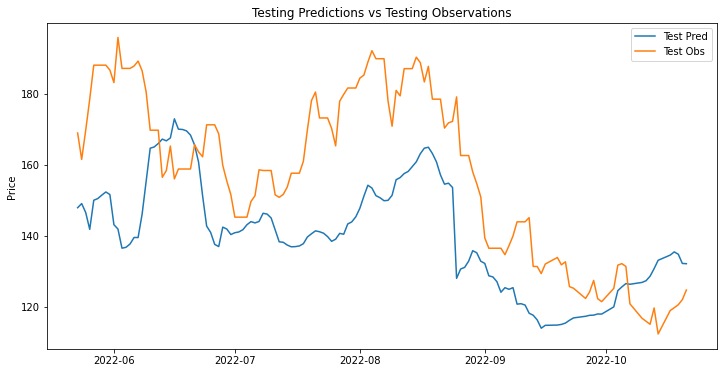

In [834]:
# Plotting testing data predictions

y_pred = lstm_model.predict(X_test).flatten()

plt.figure(figsize=(12,6))
plt.plot(X_test_date, y_pred)
plt.plot(X_test_date, y_test)
plt.legend(['Test Pred', 'Test Obs'])
plt.title('Testing Predictions vs Testing Observations')
plt.ylabel('Price')
rmse = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE', rmse)


#### Get T+10 prediction price values

1/1 [==============================] - 0s 48ms/step


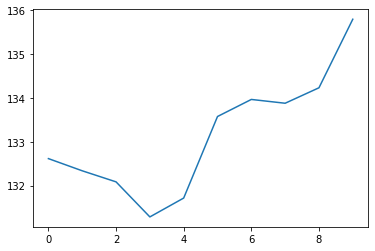

In [828]:
plt.plot(lstm_model.predict(X_actualtest).flatten())

In [842]:
pred = lstm_model.predict(X_actualtest)
pred = pd.DataFrame(pred, columns = ['Price'])

1/1 [==============================] - 0s 24ms/step


In [844]:
pred.to_csv('ChngJinYangRay_Impl_1.csv')